In [1]:
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import Point
import json
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

## Prepare the dataset_election_bfs file for the analysis
First we need to process the big file because there's a lot of not needed data and also matches which have to be brought together from the metadata

In [4]:
ELECTION_RESULTS_FILE = 'election_data/dataset_elections_bfs.json'
METADATA_FILE = 'election_data/NRW2023-metadaten.json'

In [13]:
with open(ELECTION_RESULTS_FILE) as f:
    election_results = json.load(f)
    print(election_results.keys())
with open(METADATA_FILE) as f:
    metadata = json.load(f)
    print(metadata.keys())

dict_keys(['timestamp', 'wahl_jahr', 'spatial_reference', 'stand', 'stand_kantone', 'level_ch', 'level_kantone', 'level_gemeinden'])
dict_keys(['timestamp', 'wahl_jahr', 'spatial_reference', 'quelle', 'bemerkungen', 'stand', 'stand_kantone', 'parteien', 'listenverbindungen', 'kandidat_status'])


Create a map which has the party number as the key and the party name as the value

In [26]:
party_metadata = {party['partei_id']: party['partei_bezeichnung'][0]['text'] for party in metadata['parteien']}

Extract important data from the election results

In [30]:
cantonal_results = dict()
for result in election_results['level_kantone']:
    if result['kanton_nummer'] not in cantonal_results.keys():
        cantonal_results[result['kanton_nummer']] = {
            'name': result['kanton_bezeichnung'],
            'parties': {}
        }
    cantonal_results[result['kanton_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_metadata[result['partei_id']],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }

In [31]:
municipal_results = dict()
for result in election_results['level_gemeinden']:
    if result['gemeinde_nummer'] not in municipal_results.keys():
        municipal_results[result['gemeinde_nummer']] = {
            'name': result['gemeinde_bezeichnung'],
            'parties': {}
        }
    municipal_results[result['gemeinde_nummer']]['parties'][result['partei_id']] = \
        {
            'name': party_metadata[result['partei_id']],
            'vote_share': result['partei_staerke'],
            'vote_share_delta': result['differenz_partei_staerke'],
            'strongest_party': True if result['flag_staerkste_partei'] else False
        }
municipal_results

{1: {'name': 'Aeugst am Albis',
  'parties': {1: {'name': 'FDP.Die Liberalen',
    'vote_share': 12.733669035,
    'vote_share_delta': -3.68737584,
    'strongest_party': False},
   3: {'name': 'Sozialdemokratische Partei der Schweiz',
    'vote_share': 13.582120439,
    'vote_share_delta': 2.0170183829,
    'strongest_party': False},
   4: {'name': 'Schweizerische Volkspartei',
    'vote_share': 34.241567221,
    'vote_share_delta': 3.8606078221,
    'strongest_party': True},
   7: {'name': 'Evangelische Volkspartei der Schweiz',
    'vote_share': 3.845623232,
    'vote_share_delta': 0.6181528912,
    'strongest_party': False},
   9: {'name': 'Partei der Arbeit / Solidarität',
    'vote_share': 0.193143409,
    'vote_share_delta': 0.0310330265,
    'strongest_party': False},
   12: {'name': 'Grün-Alternative (inkl. POCH)',
    'vote_share': 0.265572187,
    'vote_share_delta': -0.036542616,
    'strongest_party': False},
   13: {'name': 'GRÜNE Schweiz',
    'vote_share': 7.898185832,


In [55]:
swiss_data = geopandas.read_file('swisstopo/Hoheitsgebiete.shp')
swiss_data['color'] = '#0583D2'
swiss_data.loc[swiss_data['NAME'] == 'Schwarzenburg', 'color'] = '#FF0000'
swiss_data

,UUID,DATUM_AEND,DATUM_ERST,ERSTELL_J,ERSTELL_M,REVISION_J,REVISION_M,GRUND_AEND,HERKUNFT,HERKUNFT_J,...,KANTONSNUM,ICC,EINWOHNERZ,HIST_NR,BFS_NUMMER,GEM_TEIL,GEM_FLAECH,SHN,geometry,color
0,{D5A9677C-FE38-44F6-B0E8-3177F6252C81},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,4650.0,16065.0,3762,0,43861.0,CH18433762,"POLYGON Z ((2812956.113 1194956.023 2980.122, ...",#0583D2
1,{B55F9EAE-EB69-4468-A41C-7BB28A6699EE},2022-11-09,2008-11-24,2006,1,2023,1,Verbessert,AV,2023,...,8.0,CH,9490.0,15478.0,1631,0,43003.0,CH08001631,"POLYGON Z ((2715953.052 1184819.358 3402.836, ...",#0583D2
2,{AB2BA4A5-EB8C-40C7-A259-271DAC93C767},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,1513.0,16066.0,3746,0,34404.0,CH18433746,"POLYGON Z ((2803369.136 1191207.211 3111.081, ...",#0583D2
3,{550D0610-1EE3-4748-8F29-88072753FFDC},2022-11-09,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,18.0,CH,2391.0,16068.0,3543,0,32377.0,CH18413543,"POLYGON Z ((2757776.421 1165789.462 2730.100, ...",#0583D2
4,{5B0C1705-1D2B-4E53-9970-6BC3DE33A0F7},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,23.0,CH,10609.0,16601.0,6037,0,30191.0,CH23036037,"POLYGON Z ((2588810.990 1085590.669 3576.258, ...",#0583D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,{7FAC8A17-64F7-4920-B7EC-29A4B4F3630E},2022-11-09,2008-11-24,1997,1,2023,1,Verbessert,AV,2023,...,19.0,CH,NaN,12508.0,4257,3,NaN,CH19094257,"POLYGON Z ((2627214.259 1260872.131 482.512, 2...",#0583D2
2274,{454AF364-1D3A-4EC8-9033-B5FF8320DBB0},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,16.0,CH,NaN,14100.0,3104,2,NaN,CH16003104,"POLYGON Z ((2745229.705 1250219.359 783.966, 2...",#0583D2
2275,{CF0F9771-1C72-4F3D-9476-8D928A01C031},2022-11-09,2008-11-24,2002,1,2023,1,Verbessert,AV,2023,...,16.0,CH,NaN,14102.0,3111,3,NaN,CH16003111,"POLYGON Z ((2763958.831 1257025.919 643.663, 2...",#0583D2
2276,{3063AE38-1248-4F21-BADA-F166674E4967},2022-11-10,2008-11-24,2000,1,2023,1,Verbessert,AV,2023,...,2.0,CH,NaN,15155.0,582,2,NaN,CH02500582,"POLYGON Z ((2640788.950 1174038.050 563.770, 2...",#0583D2


<Axes: >

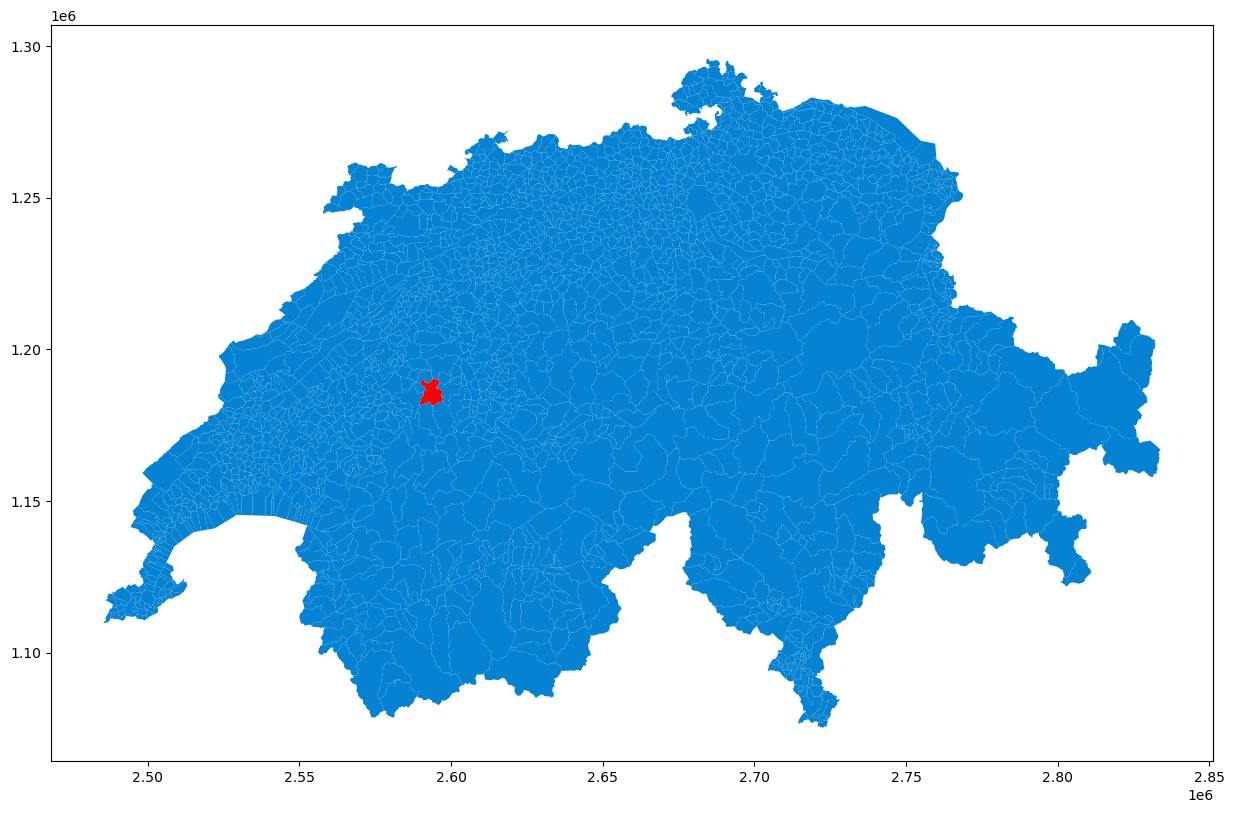

In [56]:
swiss_data.plot(color=swiss_data['color'], figsize=(15,10))